<a href="https://colab.research.google.com/github/nastyakul/garbage_classification/blob/master/Garbage_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

### Correct waste sorting is an important issue... so as packaging data science results! 

In this notebook, I'm going to work on both: I will explore the capabilities of Google Colab, while creating a simple prototype of an automated garbage classifier powered by sequential neural nets. 

We will load a toy dataset from [Kaggle](https://www.kaggle.com/asdasdasasdas/garbage-classification) and build on pre-trained MobileNetV2 from [TensorFlow Hub](https://tfhub.dev/) collection. 

Let's get started!

![alt text](https://p.kindpng.com/picc/s/130-1307073_garbage-clipart-plastic-bottle-waste-sorting-png-transparent.png)

# 1. Imports and data

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from keras.preprocessing import image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn


import glob, os, random
import itertools
import shutil

from google.colab import drive

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Store data

One thing definitely to keep in mind while using Colab is the way you get and store the data. Several options possible:

*   Manual download. No-go, since you'll need to reload everything each time you disconnect.
*   Connecting external databases. Clean way, but requires some time and effort. It's nice when you can load your data this way, but won't recommend building it from scratch for a small project.
*   Mounting your Drive. Middle way: you let Colab assess files in your Google drive and manipulate them directly. The best solution for a small project until you start working with huge datasets. I'll go for it.

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load data from Kaggle

**Disclaimer: not the safest option**

I decided to put an access token from my Kaggle account in the Drive (you'll have to do the same if you want to use the notebook) and loaded archived dataset with a simple bash command. 

In [ ]:
# Skip this cell if the dataset from Kaggle is already loaded to you drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
!kaggle datasets download -d asdasdasasdas/garbage-classification
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

In [ ]:
%cd /content/gdrive/My Drive/Kaggle
base_path = 'garbage classification/Garbage classification'
labels_dir = glob.glob(os.path.join(base_path, '*'))

/content/gdrive/My Drive/Kaggle


Great, now the dataset lives in your Google Drive. Let's see what's inside!

On a sidenote: in Colab, you can have a collapsed view of your notebook, just click on the section name and that's it. This way, you can hide unimportant cells and jump straight to the point.

# 2. Exploratory analysis

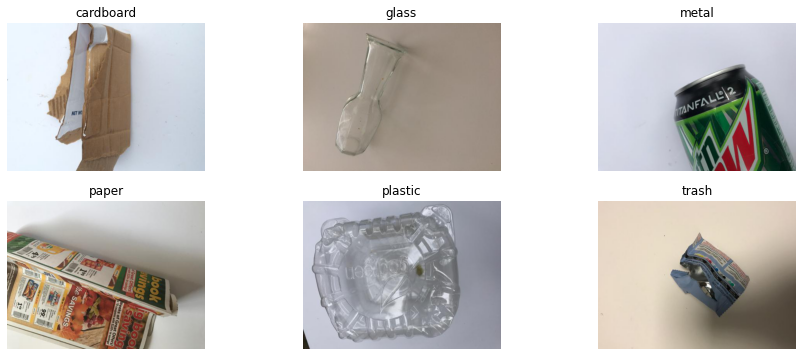

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 6))
axs = axs.ravel()

for i in range(6):
    label = labels_dir[i]
    file = random.choice(os.listdir(label))
    img = mpimg.imread(os.path.join(label, file))
    axs[i].imshow(img)
    axs[i].set_title(os.path.basename(label))
    axs[i].axis('off')

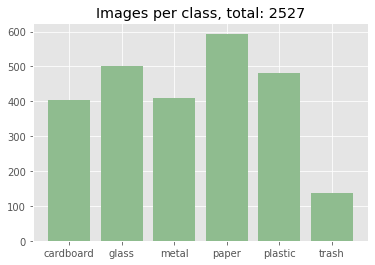

In [ ]:
plt.style.use('ggplot')
num_img = []
for label in labels_dir:
    img_for_label_list = glob.glob(os.path.join(label, '*.jpg'))
    num_img.append(len(img_for_label_list))
x = np.arange(6)
plt.bar(x, num_img, color = 'darkseagreen')
plt.xticks(x, [os.path.basename(label) for label in labels_dir])
plt.title(f'Images per class, total: {sum(num_img)}')
plt.show()

__Summary__
- we got a sense of how the dataset look like, outputing samples from each class
- we validated that classes are more or less the same size, except for "trash"

Let's move on to building a classifier!


# 3. Modeling

We will use a pre-trained [MobileNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2) model which is hosted by TensorFlow Hub.

This process is called [transfer learning](https://cs231n.github.io/transfer-learning/): 
- the model is available with all the weights obtained by training on ImageNet, thus, it already learned general features of images 
- these learnings can be reused for other more specific tasks (like our garbage classification) with significantly smaller training data
- it's computationally fast and user-friendly way to build a prototype and test hypothesis. In our case, it's "do CV models show potential in waste sorting task?"


In [ ]:
module_selection = ("mobilenet_v2_100_224", 224) 
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)

IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


## Create splits

In Keras, there's a utility function `flow_from_directory`. It loads images from dir and infers labels from folder names, so make sure your data structure is correct.

You can also set `validation_split` argument, so that it splits training data into train and validation set automatically. 

As for test set, a bit of effort is required. In my implementation, I moved 40 random samples from each class (except for "trash", there 10 would be enough) to a test directory with exactly same structure.

In [ ]:
path = os.getcwd()
if not os.path.exists('test_classifier'):
    os.makedirs('test_classifier')

test_dir = os.path.join(path, 'test_classifier')

In [ ]:
# skip this part if you already created test set
# move random samples from each category to test directory
for i in range(6):
    label = labels_dir[i]
    if os.path.basename(label) == 'trash':
      img_to_move = 10
    else:
      img_to_move = 40
    for j in range(img_to_move):
      file = random.choice(os.listdir(label))
      file_path = os.path.join(label, file)
      new_file_path = os.path.join(test_dir, os.path.basename(label))
      if not os.path.exists(new_file_path):
        os.makedirs(new_file_path)
      shutil.move(file_path, new_file_path)  

In [ ]:
data_dir = base_path
datagen_kwargs = dict(rescale=1./255, validation_split=.125)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=True, **dataflow_kwargs)

do_data_augmentation = False 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, shuffle = False, target_size=IMAGE_SIZE, 
                                                  batch_size=210,interpolation="bilinear")

Found 287 images belonging to 6 classes.
Found 2030 images belonging to 6 classes.
Found 210 images belonging to 6 classes.


## Model setup

The model architecture is going to be the following:
- input layer to ensure correct shape
- [MobileNetV2](https://arxiv.org/abs/1801.04381) feature extractor layer, which can remain non-trainable (for speed). Checkout the link to learn more about its architecture.
- dropout layer to prevent overfitting on small subset of data
- final dense layer with linear activation function, which will return probabilities of the classes

In [ ]:
do_fine_tuning = False 
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

## Train

Let's now train the model and visualize training history. We will monitor accuracy and [categorical cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy).

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
63/63 [==============================] - 82s 1s/step - loss: 1.1594 - accuracy: 0.6847 - val_loss: 1.0379 - val_accuracy: 0.7305
Epoch 2/5
63/63 [==============================] - 82s 1s/step - loss: 0.8634 - accuracy: 0.8198 - val_loss: 0.9561 - val_accuracy: 0.7617
Epoch 3/5
63/63 [==============================] - 81s 1s/step - loss: 0.7875 - accuracy: 0.8539 - val_loss: 0.8764 - val_accuracy: 0.8047
Epoch 4/5
63/63 [==============================] - 86s 1s/step - loss: 0.7379 - accuracy: 0.8754 - val_loss: 0.8192 - val_accuracy: 0.8203
Epoch 5/5
63/63 [==============================] - 81s 1s/step - loss: 0.7061 - accuracy: 0.8969 - val_loss: 0.8898 - val_accuracy: 0.8047


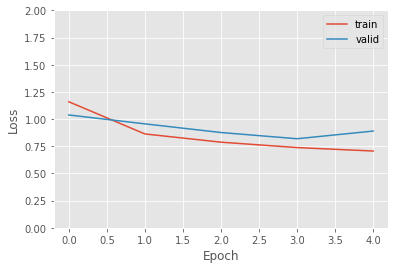

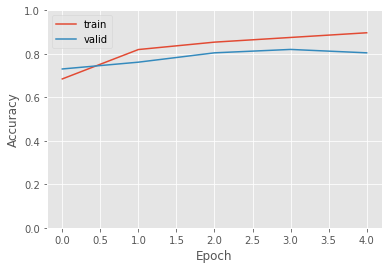

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.ylim([0,2])
plt.plot(hist["loss"], label = 'train')
plt.plot(hist["val_loss"], label = 'valid')
plt.legend()

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.ylim([0,1])
plt.plot(hist["accuracy"], label = 'train')
plt.plot(hist["val_accuracy"], label = 'valid')
plt.legend()

__Summary__

- we see that due to small size of training data, there's no stable increase in accuracy
- it doesn't look like we're learning after 5 iterations, so let's stop here

## Test

In [ ]:
# Check the images shape for testing set
for test_image_batch, test_label_batch in test_generator:
    print("Image batch shape:",test_image_batch.shape)
    print("Label batch shape:",test_label_batch.shape)
    break

Image batch shape: (210, 224, 224, 3)
Label batch shape: (210, 6)


In [ ]:
# get labels
label_names = sorted(test_generator.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])

In [ ]:
# run predictions for the test batch
result_batch = model.predict(test_image_batch)
pred_labels = label_names[np.argmax(result_batch, axis=-1)]

# get true labels
true_labels = label_names[np.argmax(test_label_batch, axis=-1)]

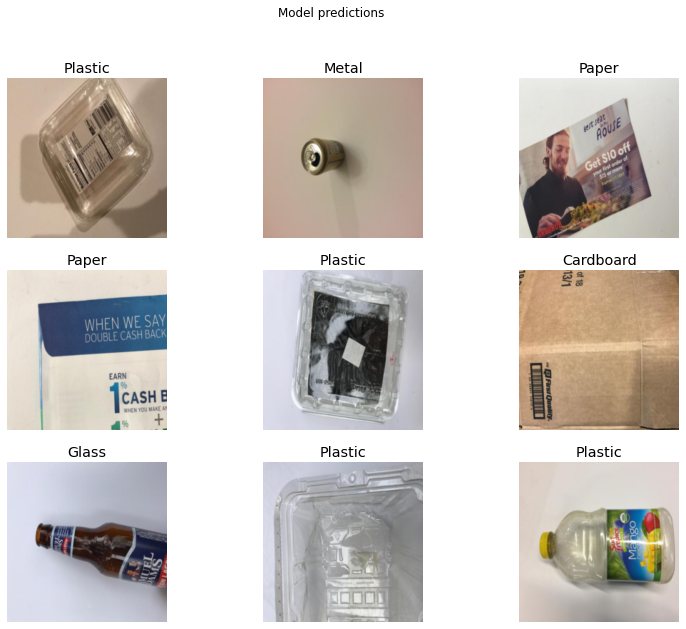

In [ ]:
# Show predicted results
plt.figure(figsize=(13,10))
for n in range(9):
  i = np.random.randint(0,210)
  plt.subplot(3,3,n+1)
  plt.imshow(test_image_batch[i])
  plt.title(pred_labels[i])
  plt.axis('off')
  plt.suptitle("Model predictions")

Looks concise, let's take a look at the metrics!


# 4. Analysis

In [ ]:
# get accuracy
accuracy_score(true_labels, pred_labels).round(2)

0.8

Text(0.5, 1.0, 'Confusion matrix')

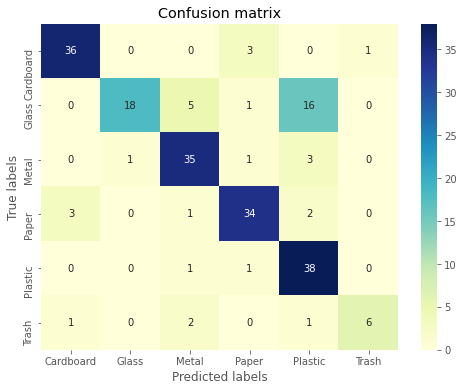

In [ ]:
# confusion matrix
df_cm = pd.DataFrame(confusion_matrix(true_labels, pred_labels, label_names),
                     index = [i for i in label_names],
                  columns = [i for i in label_names])
fig, ax = plt.subplots(figsize=(8,6)) 
sn.heatmap(df_cm, fmt="d", annot=True, cmap='YlGnBu', ax=ax)
plt.xlabel('Predicted labels')
plt.ylabel('True labels'); 
plt.title('Confusion matrix')

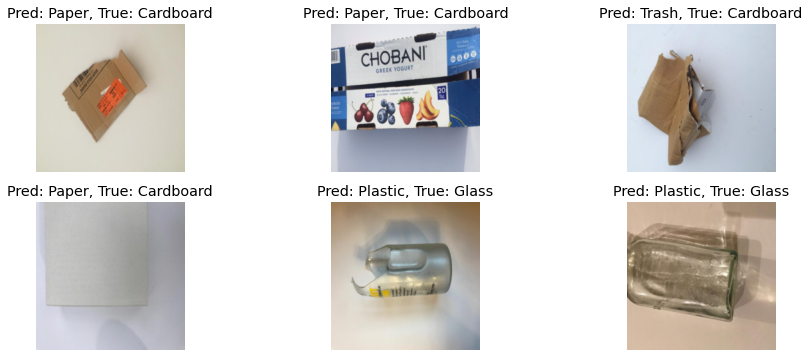

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 6))
axs = axs.ravel()

incorrect = true_labels[true_labels != pred_labels]
pred_incorrect = pred_labels[true_labels != pred_labels]
img_incorrect = test_image_batch[true_labels != pred_labels]

for i in range(6):
    axs[i].imshow(img_incorrect[i])
    axs[i].set_title(f'Pred: {pred_incorrect[i]}, True: {incorrect[i]}')
    axs[i].axis('off')

__Summary__
- the overall score is promising, however, the test consisted of only 210 images. The generalization capabilities of the model are still unknown.
- looking at confusion matrix we notice that cardboard and paper are hard to distinguish (even for humans!). Glass and plastic are mistaken in almost half of the cases, both could be transparent. As for trash, this class was underrepresented, in addition, it's hard to define any patterns here: it could be anything from unrecyclable plastic to oily paper, etc.

# Conclusion

Before we jump to the conclusion, it's always nice to play around: let's load image which doesn't belong to our dataset and test our model on it.

For that, I uploaded some extra images to the drive.

In [ ]:
img_folder_name = 'test_external'
more_img_dir = os.path.join(os.getcwd(), img_folder_name)

In [ ]:
def get_pred_for_img(img_name):
  # load and preprocess single image
  img = mpimg.imread(os.path.join(more_img_dir, img_name))
  img_processed = tf.image.resize(img, (224,224))
  img_processed = image.img_to_array(img_processed)
  img_processed = np.expand_dims(img_processed, axis=0)
  # datagen
  test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
  test_generator = test_datagen.flow(img_processed)
  # predict
  pred = model.predict(test_generator, batch_size=1)
  # plot 
  plt.imshow(img)
  plt.axis('off')
  plt.title(f'Predicted class: {label_names[np.argmax(pred, axis=-1)][0]}')

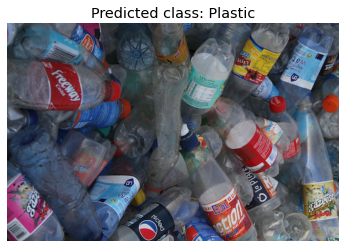

In [ ]:
get_pred_for_img('smth_1.jpg')

__Summary__
- as already stated, despite relatively good accuracy on the test set (0.8), it's too early to conclude on model's capabilities
- we spotted some evidence of overfitting, the reason could be a small dataset
- it's good to see, that predictions are interpretable

__Next steps__
- as you noticed, we didn't do any fine-tuning of KerasLayer. Definetely a thing to try! 
- we used a model trained on a generic image dataset. Perhaps, it could be better to use this (or simplified) architecture and pre-train on a dataset more related to a task.
- the dataset we're using consists of ~ 2,5k images, which is clearly not enough for computer vision tasks. I'm considering taking [another dataset](https://www.kaggle.com/techsash/waste-classification-data/activity) consisting of ~22k images. It only has two labels (organic/recyclable)... But the good news is that I can [Snorkel](https://www.snorkel.org/get-started/) which makes learning on unlabeled data possible (probabilistic labels are obtained by a set of week learners).
- like in many other tasks, mistaking one classes is more critical then others. For example, when the model mistakes trash for plastic, the quality of recycled material becomes worse. It would be nice to take that into account and design a custom metric for this task.
- playing with the notebook is fun, however, it's even more fun when models are wrapped into a nice interface. I'm thinking of try out [Streamlit](https://www.streamlit.io/) and [Flask](https://flask.palletsprojects.com/en/1.1.x/) libraries allowing to build simple ML apps.

Stay tuned!